In [1]:
# install dependencies
!pip install transformers sentencepiece scikit-learn torch rouge-score wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=1c7301d7751a36892d06d5f32dfc58db1d8f95e101e500b707d0e3d68b65d7ca
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [2]:
from sklearn.datasets import fetch_20newsgroups
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from transformers import BertModel, BertTokenizer
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [10]:
# Function to load the dataset
def load_data():
    print("Loading the 20newsgroups dataset...")
    data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
    print("Dataset loaded successfully.")

    return data

In [38]:
# Limiting to 512 tokens, preprocessing for demonstration purposes
def preprocess_text(text):
    print("Preprocessing text ...")
    return text[:512]

In [39]:
# Function to summarize using Pegasus
def summarize_with_pegasus(text):
    print("Loading Pegasus model for summarization...")
    model_name = "google/pegasus-xsum"
    tokenizer = PegasusTokenizer.from_pretrained(model_name)
    model = PegasusForConditionalGeneration.from_pretrained(model_name)

    print("Summarizing text with Pegasus...")
    inputs = tokenizer(text, max_length=1024, return_tensors="pt", truncation=True)
    summary_ids = model.generate(inputs["input_ids"])
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary

In [40]:
# Function to summarize using GPT
def summarize_with_gpt(text):
    print("Loading GPT model...")
    model_name = "gpt2"
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    model = GPT2LMHeadModel.from_pretrained(model_name)

    print("Generating text with GPT based on input...")
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    summary_ids = model.generate(inputs["input_ids"], max_length=150, num_return_sequences=1)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary

In [57]:
# Load dataset
data = load_data()
sample_text = data.data[7522][:2000]

# print(sorted([(len(x), i) for i, x in enumerate(data.data)], reverse=True)[200:400])

print("Sample Text: " + sample_text[:2000])

Loading the 20newsgroups dataset...
Dataset loaded successfully.
[(11564, 17790), (11534, 12121), (11527, 11883), (11508, 18812), (11504, 13462), (11455, 8023), (11410, 18485), (11400, 16374), (11372, 1980), (11363, 1470), (11292, 16233), (11197, 16334), (11124, 8381), (11050, 6754), (11041, 5186), (11033, 1985), (11021, 10633), (10938, 1257), (10874, 7199), (10869, 10571), (10860, 6047), (10847, 12210), (10658, 1860), (10594, 12126), (10487, 5936), (10410, 7689), (10396, 11580), (10362, 5425), (10332, 2058), (10325, 15509), (10261, 11347), (10142, 12775), (10139, 6908), (10113, 14691), (10102, 13707), (10077, 15319), (10059, 16027), (10042, 6028), (10010, 12635), (9976, 10202), (9923, 9195), (9915, 9742), (9709, 6735), (9694, 552), (9671, 18611), (9668, 10717), (9631, 15009), (9601, 17874), (9570, 6154), (9540, 612), (9526, 15111), (9524, 2191), (9520, 14707), (9505, 5011), (9499, 13396), (9495, 7749), (9478, 10700), (9450, 7590), (9438, 13179), (9350, 8475), (9315, 9578), (9268, 1196

In [58]:
# Summarize using different models
pegasus_summary = summarize_with_pegasus(sample_text)
print("Pegasus Summary: " + pegasus_summary)

Loading Pegasus model for summarization...


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Summarizing text with Pegasus...
Pegasus Summary: I've been hearing a lot about strong crypto systems being outlawed in the US.


In [59]:
gpt_summary = summarize_with_gpt(preprocess_text(sample_text))
print("GPT Summary: " + gpt_summary)

Preprocessing text ...
Loading GPT model...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating text with GPT based on input...
GPT Summary: 
Please let us know if you get a solid answer to the question of legality
of other strong cryptosystems.   So far any references I have seen
have been weasel-words ("more plans in the future, etc"), but nothing
that could be taken as a "NO (strong crypto will NOT be outlawed)".  I
have heard (not verified) that the Crime Bill before Congress has
language that either requires escrow of keys, or that will regard
all systems 'unapproved' for public use, like strong cryptosystems
not trivially broken by the Govt.  (which is why I am not
sure if the bill is actually a "no" or "no


In [60]:
from rouge_score import rouge_scorer
import nltk
from nltk.translate.bleu_score import sentence_bleu

# Install NLTK package for BLEU (if not already installed)
nltk.download('punkt')

# Function to calculate ROUGE scores
def calculate_rouge_scores(generated_summary, reference_summary):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference_summary, generated_summary)
    return scores

# Function to calculate BLEU score
def calculate_bleu_score(generated_summary, reference_summary):
    reference_tokens = nltk.word_tokenize(reference_summary)
    generated_tokens = nltk.word_tokenize(generated_summary)
    score = sentence_bleu([reference_tokens], generated_tokens)
    return score

# Example usage
reference_summary = "The text discusses the potential legal challenges surrounding the use of strong cryptographic systems. It suggests that while these systems might not be explicitly outlawed, they could be effectively banned through legal nuances. The text compares strong crypto to tools like crowbars, which can be labeled as 'burglar tools' under certain circumstances. The author speculates that possessing strong crypto without a government-approved 'legitimate need' could lead to classification as possession of 'terrorist tools.' This implies that personal privacy desires might not be considered a valid reason for using strong encryption, potentially leading to legal consequences."

# Calculate scores for Pegasus summary
rouge_scores_pegasus = calculate_rouge_scores(pegasus_summary, reference_summary)
bleu_score_pegasus = calculate_bleu_score(pegasus_summary, reference_summary)

# Calculate scores for GPT summary
rouge_scores_gpt = calculate_rouge_scores(gpt_summary, reference_summary)
bleu_score_gpt = calculate_bleu_score(gpt_summary, reference_summary)

# Print scores
print("Pegasus ROUGE Scores:", rouge_scores_pegasus)
print("Pegasus BLEU Score:", bleu_score_pegasus * 100)
print("GPT ROUGE Scores:", rouge_scores_gpt)
print("GPT BLEU Score:", bleu_score_gpt * 100)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Pegasus ROUGE Scores: {'rouge1': Score(precision=0.4666666666666667, recall=0.07291666666666667, fmeasure=0.12612612612612614), 'rouge2': Score(precision=0.07142857142857142, recall=0.010526315789473684, fmeasure=0.018348623853211007), 'rougeL': Score(precision=0.3333333333333333, recall=0.052083333333333336, fmeasure=0.0900900900900901)}
Pegasus BLEU Score: 2.223245667031985e-155
GPT ROUGE Scores: {'rouge1': Score(precision=0.2857142857142857, recall=0.3125, fmeasure=0.29850746268656714), 'rouge2': Score(precision=0.028846153846153848, recall=0.031578947368421054, fmeasure=0.030150753768844223), 'rougeL': Score(precision=0.1619047619047619, recall=0.17708333333333334, fmeasure=0.1691542288557214)}
GPT BLEU Score: 3.7952296482446424e-153


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


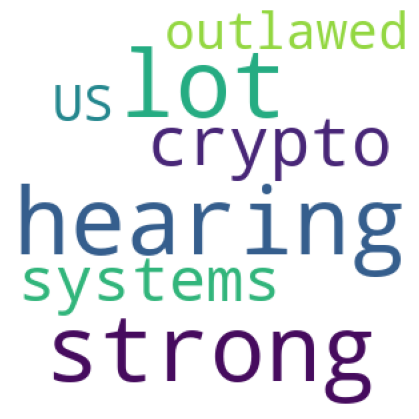

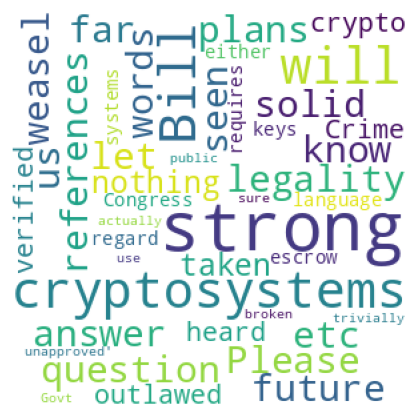

In [61]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt



def draw_wordcloud(generated_summary):
  # Generate a word cloud image
  wordcloud = WordCloud(width = 300, height = 300,
                  background_color ='white',
                  stopwords = None,
                  min_font_size = 6).generate(generated_summary)

  # Display the generated image
  plt.figure(figsize = (4, 4), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

  plt.show()

draw_wordcloud(pegasus_summary)
draw_wordcloud(gpt_summary)